Epoch 1/100
10/10 [==============================] - 4s 385ms/step - loss: 0.0550 - val_loss: 0.0345
Epoch 2/100
10/10 [==============================] - 0s 47ms/step - loss: 0.0053 - val_loss: 0.1868
Epoch 3/100
10/10 [==============================] - 0s 28ms/step - loss: 0.0109 - val_loss: 0.0451
Epoch 4/100
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - val_loss: 0.0065
Epoch 5/100
10/10 [==============================] - 0s 35ms/step - loss: 5.6224e-04 - val_loss: 1.3629e-05
Epoch 6/100
10/10 [==============================] - 0s 30ms/step - loss: 4.7872e-04 - val_loss: 5.2822e-04
Epoch 7/100
10/10 [==============================] - 0s 34ms/step - loss: 1.2446e-04 - val_loss: 2.8057e-04
Epoch 8/100
10/10 [==============================] - 0s 25ms/step - loss: 1.5041e-04 - val_loss: 0.0090
Epoch 9/100
10/10 [==============================] - 0s 26ms/step - loss: 5.3941e-04 - val_loss: 0.0011
Epoch 10/100
10/10 [==============================] - 0s 23ms/step 

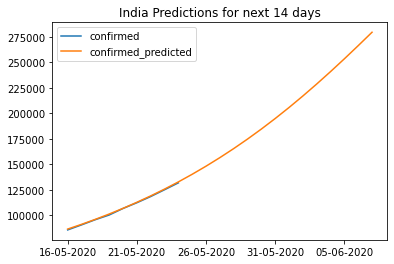

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

#Reading Data
df = pd.read_csv('Confirmed.csv',index_col='Date')

#Splitting
test_data_size = 9
train = df[:-test_data_size]
test = df[-test_data_size:]

#Scaling in range(0,)
scaler = MinMaxScaler()
scaler.fit(train)
MinMaxScaler(copy=True, feature_range=(0, 1))

#Scaled Test and Trained Data
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 5  ## number of steps
n_features = 1 ## number of features you want to predict
generator = TimeseriesGenerator(scaled_train,scaled_train,length = n_input,batch_size=1)

#Modeling using RNN 
model = Sequential()
model.add(LSTM(250,input_shape=(n_input,n_features)))
model.add(Dense(80))
model.add(Dense(units=1))
model.compile(optimizer="adam",loss="mse")

#Validation and Training Model
validation_set = np.append(scaled_train[19],scaled_test)
validation_set= validation_set.reshape(10,1)
n_input = 5
n_features = 1
validation_gen = TimeseriesGenerator(validation_set,validation_set,length=5,batch_size=1)
early_stop = EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)
model.fit_generator(generator,validation_data=validation_gen,callbacks=[early_stop],epochs=100,steps_per_epoch=10)


## holding predictions
test_prediction = []

##last n points from training set
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)

## how far in future we can predict
for i in range(len(test)+14):
    current_pred = model.predict(current_batch)[0]
    test_prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
    
### inverse scaled data
true_prediction = scaler.inverse_transform(test_prediction)

from pandas.tseries.offsets import DateOffset
from datetime import datetime
time_series_array = test.index
for k in range(0,13):
    time_series_array = test.index
    nextd=pd.date_range('25-05-2020',periods=14)
    nextd=nextd.strftime('%d-%m-%Y')
    time_series_array = time_series_array.append(nextd)
    
#Forecast
df_forecast = pd.DataFrame(index=time_series_array)
df_forecast.loc[:,"confirmed"] = test
df_forecast["confirmed_predicted"] = true_prediction[:,0]
print(df_forecast)

#Plotting the Data
df_forecast.plot(title="India Predictions for next 14 days")